In [1]:
### Import the required libraries

from __future__ import print_function, division
import torchvision
from torchvision import datasets, transforms
from torchvision.transforms import ColorJitter
from torch.utils.data import Dataset
from PIL import Image
from torch.utils.data import random_split,DataLoader
import os
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset
from torch_geometric.loader import DataLoader
from torchvision import transforms, utils
from torchvision import io
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
import torch.nn.functional as F
import cv2
import torch.nn as nn
import torch_geometric.nn as gnn
from torcheval.metrics.functional import r2_score


In [2]:
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# os.environ['CUDA_VISIBLE_DEVICES'] ='0'

In [3]:
# ### preprocessing the images using CLAHE algorithm

class FaceLandmarksDataset(Dataset):

    def __init__(self, csv_file, root_dir, transform=None):
        self.landmarks_frame = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.landmarks_frame)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = os.path.join(self.root_dir,
                                self.landmarks_frame.iloc[idx, -1])

#clahe algorithm
        image = cv2.imread(img_name)
#         image = cv2.resize(image, (16, 16))
        hsv_img = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
        h, s, v = hsv_img[:,:,0], hsv_img[:,:,1], hsv_img[:,:,2]
        clahe = cv2.createCLAHE(clipLimit = 15.0, tileGridSize = (20,20))
        v = clahe.apply(v)
        hsv_img = np.dstack((h,s,v))
        image = cv2.cvtColor(hsv_img, cv2.COLOR_HSV2RGB)
        image = torch.from_numpy(image)

        image_shape = image.shape
        x = torch.reshape(image, (image_shape[1] * image_shape[2], -1))
        self.num_nodes = x.shape[0]
        self.num_node_features = x.shape[1]
        first_row = []
        for i in range(0, image_shape[1]):
            first_row = first_row + [i] * image_shape[2]
        second_row = [*range(0, image_shape[1])] * image_shape[2]
        edge_index = torch.tensor([first_row, second_row], dtype=torch.int64)
        self.num_edges = edge_index.shape[1]
        data = Data(x=x, edge_index=edge_index)
        landmarks = self.landmarks_frame.iloc[idx, :-1]
        landmarks = np.array([landmarks]).tolist()[0]
        self.landmarks_len = len(landmarks)
        sample = {'image': data, 'landmarks': landmarks}

        if self.transform:
            sample = self.transform(sample)

        return data, landmarks


In [4]:
def data_prepare():
    face_dataset = FaceLandmarksDataset(csv_file='landmarks.csv', root_dir='dataset')


    # Split the dataset into train and test sets
    train_size = int(0.8 * len(face_dataset))
    test_size = len(face_dataset) - train_size
    train_dataset, test_dataset = random_split(face_dataset, [train_size, test_size])
    
    print(train_dataset)

    # Create a DataLoader for the training set
    train_loader = DataLoader(dataset=train_dataset, batch_size=4, shuffle=True)

    # Create a DataLoader for the test set
    test_loader = DataLoader(dataset=test_dataset, batch_size=4, shuffle=False)
    
    return train_loader,test_loader


In [5]:
train_loader,test_loader=data_prepare()
# i=1
# for image,label in test_loader:
#     print(label)
#     print(i)
#     i=i+1

In [6]:
class GCNN(nn.Module):
    def __init__(self, num_features ,num_classes):
        super(GCNN, self).__init__()
        self.conv1 = gnn.GraphConv(num_features,16)
        self.conv2 = gnn.GraphConv(16, num_classes)

        
    def forward(self, x, edge_index):
        # Apply graph convolutional layers
        edge_index = edge_index.to(torch.int64)
        y = self.conv1(x.to(torch.float32), edge_index)
        y = torch.relu(y)
        y = self.conv2(y.to(torch.float32), edge_index)
        return y

In [7]:
# ### initializing the GCNN model

model = GCNN(2304, 1)




#defining the loss function and optimizer
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)




In [8]:
### training the GCNN model
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device=torch.device('cpu')

for epoch in range(0,1):
    print(f"Training.........epoch-{epoch}")
    train_loss = 0.0
    i=0
    e_loss=[]
    r2_score_train=[]
    for images,labels in train_loader:
        i=i+1
        print(f"databatch {i}................................")
        images = images.to(device)
        x=images.x
        x = x.to(torch.int64)
        edge_index=images.edge_index
        edge_index=edge_index.to(torch.int64)
        labels=torch.cat(labels,dim=0)
        model=model.to(device)
        output = model(x,edge_index)
        num_rows = output.shape[0]
        num_repeats = num_rows // len(labels) + 1
        labels = labels.repeat(num_repeats)[:num_rows]

        labels=labels.to(device)
        output=output.to(device)
        output=output.squeeze()
        loss = criterion(output, labels)
        r2=r2_score(output,labels)
        r2_score_train.append(r2)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        e_loss.append(loss)
    
        
    print("Epoch: {} Train Loss: {}".format(epoch+1, sum(e_loss)/i))
    print("Epoch: {} Train R2 Score: {}".format(epoch+1, np.absolute(sum(r2_score_train)/i)))

Training.........epoch-0
databatch 1................................
databatch 2................................
databatch 3................................
databatch 4................................
databatch 5................................
databatch 6................................
databatch 7................................
databatch 8................................
databatch 9................................
databatch 10................................
databatch 11................................
databatch 12................................
databatch 13................................
databatch 14................................
databatch 15................................
databatch 16................................
databatch 17................................
databatch 18................................
databatch 19................................
databatch 20................................
databatch 21................................
databatch 22...........................

databatch 181................................
databatch 182................................
databatch 183................................
databatch 184................................
databatch 185................................
databatch 186................................
databatch 187................................
databatch 188................................
databatch 189................................
databatch 190................................
databatch 191................................
databatch 192................................
databatch 193................................
databatch 194................................
databatch 195................................
databatch 196................................
databatch 197................................
databatch 198................................
databatch 199................................
databatch 200................................
databatch 201................................
databatch 202.....................

In [9]:

# Testing of GCNN Model

with torch.no_grad():
    i=0
    test_loss=[]
    r2_score_test=[]
    for images, labels in test_loader:
        print(f"Testing............{i+1}")
        images = images.to(device)
        x = images.x.to(torch.float32)
        edge_index = images.edge_index
        edge_index=edge_index.to(torch.int64)
        labels=torch.cat(labels,dim=0)
        output = model(x, edge_index)
        
        labels = labels.to(torch.float32)
        num_rows = output.shape[0]
        num_repeats = num_rows // len(labels) + 1
        labels = labels.repeat(num_repeats)[:num_rows]
        output=output.squeeze()
        
       
        loss = torch.nn.functional.mse_loss(output, labels, reduction='sum')
        r2_test=r2_score(output,labels)
        test_loss.append(loss)
        r2_score_test.append(r2_test)
        i=i+1

    
    print("Test MSE Loss: {}".format(sum(test_loss)/i))
    print("Test R2 Score: {}".format(np.absolute(sum(r2_score_test)/i)))

Testing............1
Testing............2
Testing............3
Testing............4
Testing............5
Testing............6
Testing............7
Testing............8
Testing............9
Testing............10
Testing............11
Testing............12
Testing............13
Testing............14
Testing............15
Testing............16
Testing............17
Testing............18
Testing............19
Testing............20
Testing............21
Testing............22
Testing............23
Testing............24
Testing............25
Testing............26
Testing............27
Testing............28
Testing............29
Testing............30
Testing............31
Testing............32
Testing............33
Testing............34
Testing............35
Testing............36
Testing............37
Testing............38
Testing............39
Testing............40
Testing............41
Testing............42
Testing............43
Testing............44
Testing............45
Testing............

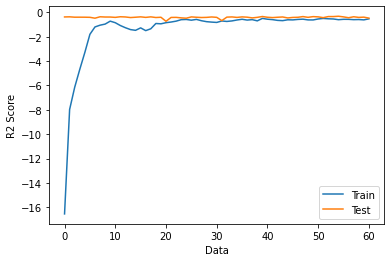

In [10]:
#Visualization of Model Otputs in Train and Test for R2 Score



r2_score_train=np.array([t.item() for t in r2_score_train])
r2_score_test=np.array([t.item() for t in r2_score_test])


plt.plot(r2_score_train[:len(r2_score_test)], label="Train")
plt.plot(r2_score_test, label="Test")
plt.xlabel("Data")
plt.ylabel("R2 Score")
plt.legend()
plt.show()



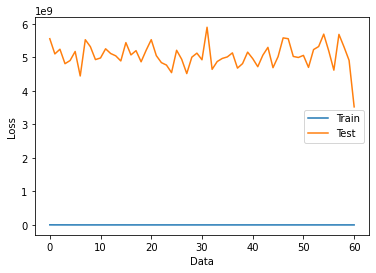

In [11]:
#Visualization of Model Otputs in Train and Test for MSE Loss


e_loss=np.array([t.item() for t in e_loss])
test_loss=np.array([t.item() for t in test_loss])


plt.plot(e_loss[:len(test_loss)], label="Train")
plt.plot(test_loss, label="Test")
plt.xlabel("Data")
plt.ylabel("Loss")
plt.legend()
plt.show()